# Transformer Implementation from Scratch in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import os
import random
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


# Hyperparameters

In [2]:
hyperparameters = {
    'lags': 90,
    'forecast': 10,
    'input_features_size': 16,
    'date_input_features_size': 3, # (MONTH, DAY, HOUR)
    'date_features_dim': 64,
    'hidden_features_size': 256-64,
    'output_features_size': 16,
    'num_heads': 4,
    'ff_dim': 256*4, # usually 4 times the hidden feature size
    'num_decoder_layers': 6,
    'emb_dropout_prob': 0.1,
    'attn_dropout_prob': 0.1,
    'ff_dropout_prob': 0.1,
    'attn_use_bias': False,
    'ff_use_bias': False,
    'output_features_bias': False,
    'batch_size': 64,
    'split_ratio': 0.8, # 80% training, 20% testing
    'learning_rate': 0.001,
    'num_epochs': 50,
    'use_amp': True, # USE MIXED PRECISION
}

hyperparameters['window_size'] =  hyperparameters['lags'] + hyperparameters['forecast']

# Dataset

In [3]:
# Airline Passgeners
#df_full = pd.read_csv('data/airline_passengers/airline-passengers.csv')

# Panama Electricity Load Forecasting
df_full = pd.read_csv('data/panama_electricity_load_forecasting/train.csv')

df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [4]:
# Airline Passgeners
#df_full['Month'] = pd.to_datetime(df_full['Month'])

# Panama Electricity Load Forecasting
df_full['datetime'] = pd.to_datetime(df_full['datetime'], dayfirst=True)

df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [5]:
# # Airline Passgeners
#df_full.set_index('Month', inplace=True)

# Panama Electricity Load Forecasting
df_full.set_index('datetime', inplace=True)

df_full.tail()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-12-31 19:00:00,1301.6065,26.635645,0.018421,0.013165,13.184052,25.135645,0.018048,0.064240,3.086798,23.620020,0.016697,0.073425,3.865351,22,1,0
2019-12-31 20:00:00,1250.9634,26.495935,0.018162,0.014713,13.443892,24.769373,0.017781,0.058838,3.659980,23.284998,0.016606,0.064362,4.171572,22,1,0
2019-12-31 21:00:00,1193.6802,26.354456,0.017980,0.013836,13.442195,24.479456,0.017606,0.038086,3.769294,23.041956,0.016492,0.054260,4.045283,22,1,0
2019-12-31 22:00:00,1130.4575,26.166895,0.017965,0.018486,13.420656,24.112207,0.017393,0.020386,3.872397,22.862207,0.016401,0.055557,3.843736,22,1,0
2019-12-31 23:00:00,1084.4737,25.976373,0.018072,0.023315,13.749788,23.663873,0.017156,0.019531,4.165276,22.726373,0.016302,0.061371,3.793209,22,1,0


<Axes: xlabel='datetime'>

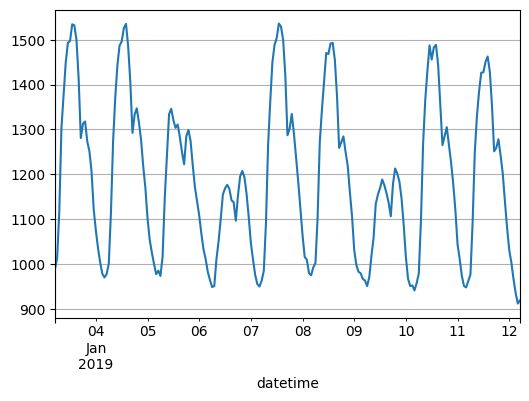

In [6]:
# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

# Standart Scaler
* Exercise: Try without scaler, see if learning works!

<Axes: xlabel='datetime'>

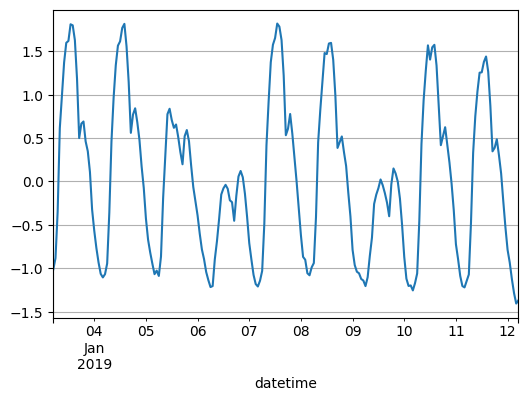

In [7]:
scaler = StandardScaler()

# Airline Passgeners
#df_full['Passengers'] = scaler.fit_transform(df_full['Passengers'].values.reshape(-1, 1))

# Panama Electricity Load Forecasting
df_full['nat_demand'] = scaler.fit_transform(df_full['nat_demand'].values.reshape(-1, 1))

# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

In [8]:
tstamp = df_full.index[-1]
tstamp

Timestamp('2019-12-31 23:00:00')

### Time series data shape: 
Unbatched: $(S, F)$

* $S:$ Sequence Length
* $F:$ Number of Features

Batched: $(B, S, F)$
* $B:$ Batch Size

In [9]:
df_full.shape

(43775, 16)

# Model

In [10]:
from models.transformer import GPTTimeSeries

## Transformer Model
### Initialized Model with Hyperparameters

In [11]:
gpt_model = GPTTimeSeries(
    input_features_size=hyperparameters['input_features_size'],
    date_input_features_size=hyperparameters['date_input_features_size'],
    date_features_dim=hyperparameters['date_features_dim'],
    features_dim=hyperparameters['hidden_features_size'],
    output_features_size=hyperparameters['output_features_size'],
    num_heads=hyperparameters['num_heads'],
    ff_dim=hyperparameters['ff_dim'],
    num_decoder_layers=hyperparameters['num_decoder_layers'],
    emb_dropout_prob=hyperparameters['emb_dropout_prob'],
    attn_dropout_prob=hyperparameters['attn_dropout_prob'],
    ff_dropout_prob=hyperparameters['ff_dropout_prob'],
    attn_use_bias=hyperparameters['attn_use_bias'],
    ff_use_bias=hyperparameters['ff_use_bias'],
    output_features_bias=hyperparameters['output_features_bias'],
)


class ForecastModel(nn.Module):
    def __init__(self, gpt_model, forecast_size):
        super().__init__()
        self.gpt_model = gpt_model
        self.forecast_size = forecast_size

    def forward(self, x_input, date_input):
        out = self.gpt_model(x_input, date_input)
        # Slice forecast
        out = out[:, -self.forecast_size:, :]
        return out


model = ForecastModel(gpt_model, hyperparameters['forecast'])

### Number of parameters

In [12]:
def print_model_parameters(model):
    print(f'{sum(p.numel() for p in model.parameters()):,}')

In [13]:
print('Number of parameters:')
print_model_parameters(model)

Number of parameters:
4,732,864


In [14]:
# "1" is the batch, single sample to speed it up
dummy_data = torch.randn(1, hyperparameters['window_size'], hyperparameters['input_features_size'])
dummy_date = torch.randn(1, hyperparameters['window_size'], hyperparameters['date_input_features_size'])

o = model(dummy_data, dummy_date)
o.shape

torch.Size([1, 10, 16])

# Sliding Window 
*  **NOTE: "hyperparameters['lags'] + hyperparameters['forecast'] = hyperparameters['window_size']" MUST HOLD**

### Slide Methods

In [15]:
dummy_data = list(range(100))

# increase by 1
single_step = range(0, len(dummy_data)-hyperparameters['window_size']+1, 1)
# increase by hyperparameters['window_size']
window_step = range(0, len(dummy_data)-hyperparameters['window_size']+1, hyperparameters['window_size'])


#for start_index in single_step:
for start_index in window_step:
    print(f"Start: {start_index}, End: {start_index+hyperparameters['window_size']}")

    # Slice window from data 
    data_window = dummy_data[start_index:start_index+hyperparameters['window_size']]

    # Split current window into lags and forecast
    data_lag = data_window[:hyperparameters['lags']]
    data_forecast = data_window[-hyperparameters['forecast']:]

    print(f'Lag: {data_lag}, forecast: {data_forecast}')

Start: 0, End: 100
Lag: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], forecast: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


# Dataset

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, lags, forecast):
        self.df = df
        self.lags = lags
        self.forecast = forecast
        self.window_size = lags + forecast
        
    def __len__(self):
        number_of_samples = self.df.shape[0]
        # make sure that last window fits
        return number_of_samples - self.window_size

    def __getitem__(self, start_idx):

        # get a NumPy array of size: (hyperparameters['window_size'], NUM_FEATURES)
        df_window = self.df.iloc[start_idx:start_idx+self.window_size]

        sample_window = df_window.values
        # input (lag) timestamps
        sample_timestamp = df_window[:self.lags].index
            
        # divide window into lags and forecast:
        # (hyperparameters['lags'], NUM_FEATURES)
        lags = sample_window[:self.lags, :]
        # (hyperparameters['forecast'], NUM_FEATURES)
        forecast = sample_window[-self.forecast:, :]

        # convert to tensor
        lags = torch.tensor(lags, dtype=torch.float32)
        forecast = torch.tensor(forecast, dtype=torch.float32)
        # (lags, date_input_features_size)
        date = torch.tensor([sample_timestamp.month, sample_timestamp.day, sample_timestamp.hour], dtype=torch.float32).permute(1, 0)
        return lags, forecast, date

In [17]:
dataset_full = TimeSeriesDataset(
    df_full,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

In [18]:
_lags, _forecast, _date = dataset_full[0]
_lags.shape, _forecast.shape, _date.shape

(torch.Size([90, 16]), torch.Size([10, 16]), torch.Size([90, 3]))

### Train/Test Split

In [19]:
train_size = int(hyperparameters['split_ratio'] * len(dataset_full))
test_size = len(dataset_full) - train_size

train_size, test_size

(34940, 8735)

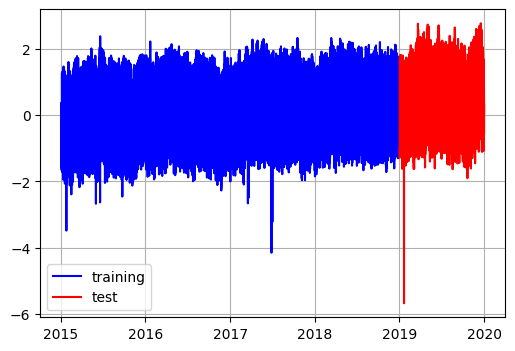

In [20]:
df_train = df_full.iloc[:train_size, :]
df_test = df_full.iloc[-test_size:, :]

# Airline Passgeners
#plt.plot(df_train.index, df_train['Passengers'], c='blue', label='training')
#plt.plot(df_test.index, df_test['Passengers'], c='red', label='test')

# Panama Electricity Load Forecasting
plt.plot(df_train.index, df_train['nat_demand'], c='blue', label='training')
plt.plot(df_test.index, df_test['nat_demand'], c='red', label='test')

plt.legend()

In [21]:
dataset_train = TimeSeriesDataset(
    df_train,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

dataset_test = TimeSeriesDataset(
    df_test,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

# Dataloader

In [22]:
dataloader_full = DataLoader(
    dataset_full,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

print(f'Number of batches (total): {len(dataloader_full)}')
print(f'Number of batches (train): {len(dataloader_train)}')
print(f'Number of batches (test): {len(dataloader_test)}')

Number of batches (total): 683
Number of batches (train): 545
Number of batches (test): 135


In [23]:
_lags_batch, _forecast_batch, _date_batch = next(iter(dataloader_full))
# (hyperparameters['batch_size'], hyperparameters['lags'], NUM_FEATURES), # (hyperparameters['batch_size'], hyperparameters['forecast'], NUM_FEATURES)
_lags_batch.shape, _forecast_batch.shape, _date_batch.shape

(torch.Size([64, 90, 16]), torch.Size([64, 10, 16]), torch.Size([64, 90, 3]))

In [24]:
len(dataloader_full)

683

# Training

### Training Functions
* with AMP support

In [25]:
def train_iter(model, dataloader, optimizer, criterion, scaler, use_amp, device):
    model.train()

    avg_loss = []
    
    for (lags, forecast, date) in dataloader:

        lags = lags.to(device)
        forecast = forecast.to(device)
        date = date.to(device)
        
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            # AMP forward pass
            forecast_pred = model(lags, date)
            loss = criterion(forecast_pred, forecast)
        
        scaler.scale(loss).backward()  #loss.backward()
        scaler.step(optimizer)         #optimizer.step()
        scaler.update()
        optimizer.zero_grad()

        avg_loss.append(loss.item())

    return sum(avg_loss) / len(avg_loss)


@torch.no_grad()
def eval_iter(model, dataloader, criterion, use_amp, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    for (lags, forecast, date) in dataloader:
        
        lags = lags.to(device)
        forecast = forecast.to(device)
        date = date.to(device)
                
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            # AMP forward pass
            forecast_pred = model(lags, date)
            loss = criterion(forecast_pred, forecast)
        
        avg_loss.append(loss.item())
        predictions.append(forecast_pred)

    return sum(avg_loss) / len(avg_loss), predictions

### Start Training

In [26]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparameters['learning_rate']
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', 
    factor=0.1, 
    patience=3,
    min_lr=1e-6,
)

scaler = torch.cuda.amp.GradScaler(enabled=hyperparameters['use_amp'])

mse_loss = nn.MSELoss()

In [27]:
model.to(device)

for epoch in range(1, hyperparameters['num_epochs']+1):
        
    avg_train_loss = train_iter(
        model=model, 
        dataloader=dataloader_train, 
        optimizer=optimizer, 
        criterion=mse_loss, 
        scaler=scaler, 
        use_amp=hyperparameters['use_amp'], 
        device=device
    )
    
    avg_test_loss, _ = eval_iter(
        model=model, 
        dataloader=dataloader_test, 
        criterion=mse_loss, 
        use_amp=hyperparameters['use_amp'],
        device=device
    )

    # auto decrease LR when not improving
    scheduler.step(avg_test_loss)
    
    """
    # MANUAL LR SCHEDULING
    if epoch == 30:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1

    if epoch == 60:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1
    """
    
    print(f'Epoch: {epoch:<3}| Training loss: {avg_train_loss:.4f}, Testing Loss: {avg_test_loss:.4f}, LR: {scheduler.get_last_lr()}')

Epoch: 1  | Training loss: 14.7931, Testing Loss: 6.5983, LR: [0.001]
Epoch: 2  | Training loss: 5.3708, Testing Loss: 6.0088, LR: [0.001]
Epoch: 3  | Training loss: 4.8393, Testing Loss: 5.6306, LR: [0.001]
Epoch: 4  | Training loss: 4.3104, Testing Loss: 4.6949, LR: [0.001]
Epoch: 5  | Training loss: 3.5818, Testing Loss: 4.0293, LR: [0.001]
Epoch: 6  | Training loss: 2.7168, Testing Loss: 2.6457, LR: [0.001]
Epoch: 7  | Training loss: 2.2389, Testing Loss: 2.3966, LR: [0.001]
Epoch: 8  | Training loss: 2.1324, Testing Loss: 2.2941, LR: [0.001]
Epoch: 9  | Training loss: 2.0752, Testing Loss: 2.1945, LR: [0.001]
Epoch: 10 | Training loss: 2.0299, Testing Loss: 2.2409, LR: [0.001]
Epoch: 11 | Training loss: 2.0034, Testing Loss: 2.2376, LR: [0.001]
Epoch: 12 | Training loss: 1.9711, Testing Loss: 2.1992, LR: [0.001]
Epoch: 13 | Training loss: 1.9399, Testing Loss: 2.1821, LR: [0.001]
Epoch: 14 | Training loss: 1.9023, Testing Loss: 2.1468, LR: [0.001]
Epoch: 15 | Training loss: 1.8038

# Testing
* NOTE: we prefer to use single windows step during prediction

In [28]:
@torch.no_grad()
def eval_iter_single_step(model, dataloader, criterion, use_amp, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    # single step
    for start_idx in tqdm(range(0, len(df_test))):

        # single step window sliding
        df_window = df_test.iloc[start_idx:start_idx+hyperparameters['window_size'], :]
        
        sample_window = df_window.values
        # input (lag) timestamps
        sample_timestamp = df_window[:hyperparameters['lags']].index

        # covnert to tensor
        lags = torch.tensor(sample_window[:hyperparameters['lags']], dtype=torch.float32, device=device)
        forecast = torch.tensor(sample_window[-hyperparameters['forecast']:], dtype=torch.float32, device=device)
        # (lags, date_input_features_size)
        date = torch.tensor([sample_timestamp.month, sample_timestamp.day, sample_timestamp.hour], dtype=torch.float32, device=device).permute(1, 0)
        
        # artificially add batch dimension
        # (we are not using the dataloader here!)
        lags = lags.unsqueeze(0)
        forecast = forecast.unsqueeze(0)
        date = date.unsqueeze(0)

        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            forecast_pred = model(lags, date)
            loss = criterion(forecast_pred, forecast)
        
        avg_loss.append(loss.item())
        # (batch, forecast, output_features_size)-> (1, 1, output_features_size)
        predictions.append(forecast_pred[0][0].cpu().numpy())

    return sum(avg_loss) / len(avg_loss), predictions

In [29]:
_, pred_sliding = eval_iter_single_step(
    model=model, 
    dataloader=dataloader_test, 
    criterion=mse_loss,
    use_amp=hyperparameters['use_amp'],
    device=device
)

len(pred_sliding)

100%|██████████████████████████████████████████████████████████████████████████| 8735/8735 [00:48<00:00, 181.05it/s]


8735

In [30]:
df_full.columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [31]:
sliding_results_dict = {}

pred_sliding_array = np.array(pred_sliding)

for feature_id, feature_key in enumerate(df_full.columns):
    sliding_results_dict[feature_key] = pred_sliding_array[:, feature_id]
        
df_sliding = pd.DataFrame(data=sliding_results_dict, index=df_test.index)

df_sliding.head(10)

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-01-02 01:00:00,0.118713,25.531250,0.019608,-0.005749,23.218750,24.140625,0.010696,0.017776,9.843750,22.578125,0.012039,0.030518,5.304688,0.232422,0.030319,0.252930
2019-01-02 02:00:00,0.002943,25.500000,0.019638,-0.001227,22.968750,24.093750,0.010750,0.018555,9.968750,22.546875,0.012131,0.033844,5.375000,0.145996,0.024017,0.244263
2019-01-02 03:00:00,-0.251465,25.453125,0.019516,0.002779,22.656250,23.890625,0.010895,0.016113,9.945312,22.375000,0.012169,0.031799,5.398438,0.106201,0.023865,0.257568
2019-01-02 04:00:00,-0.440430,25.375000,0.019547,0.009972,22.062500,23.687500,0.011192,0.021683,9.789062,22.265625,0.012421,0.039642,5.464844,0.159058,0.031189,0.291504
2019-01-02 05:00:00,-0.657715,25.296875,0.019608,0.016983,21.328125,23.484375,0.011528,0.026367,9.531250,22.140625,0.012733,0.046509,5.468750,0.161011,0.031555,0.344971
2019-01-02 06:00:00,-0.796875,25.203125,0.019608,0.021210,21.109375,23.312500,0.011719,0.028534,9.531250,22.015625,0.012886,0.050446,5.562500,0.181885,0.033234,0.368408
2019-01-02 07:00:00,-0.787598,25.093750,0.019684,0.015579,21.734375,23.203125,0.011490,0.019913,9.726562,21.875000,0.012779,0.040588,5.636719,0.082092,0.012199,0.358643
2019-01-02 08:00:00,-0.838379,25.031250,0.019699,0.015701,21.296875,23.078125,0.011520,0.017395,9.570312,21.750000,0.012871,0.038147,5.609375,0.013733,-0.004639,0.381104
2019-01-02 09:00:00,-0.864746,24.921875,0.019714,0.016388,20.953125,22.937500,0.011490,0.014450,9.523438,21.593750,0.012886,0.034668,5.585938,-0.026108,-0.014534,0.381348


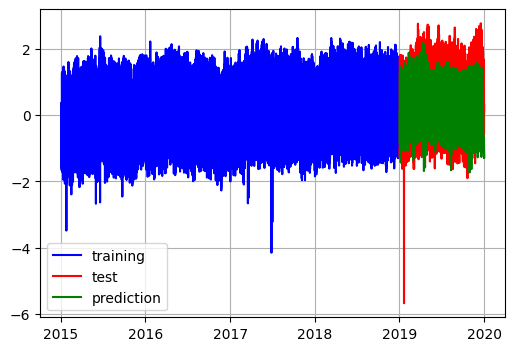

In [32]:
selected_feature = 'nat_demand'
plt.plot(df_train.index, df_train[selected_feature], c='blue', label='training')
plt.plot(df_sliding.index, df_test[selected_feature], c='red', label='test')
plt.plot(df_sliding.index, df_sliding[selected_feature] , c='green', label='prediction')
plt.legend()

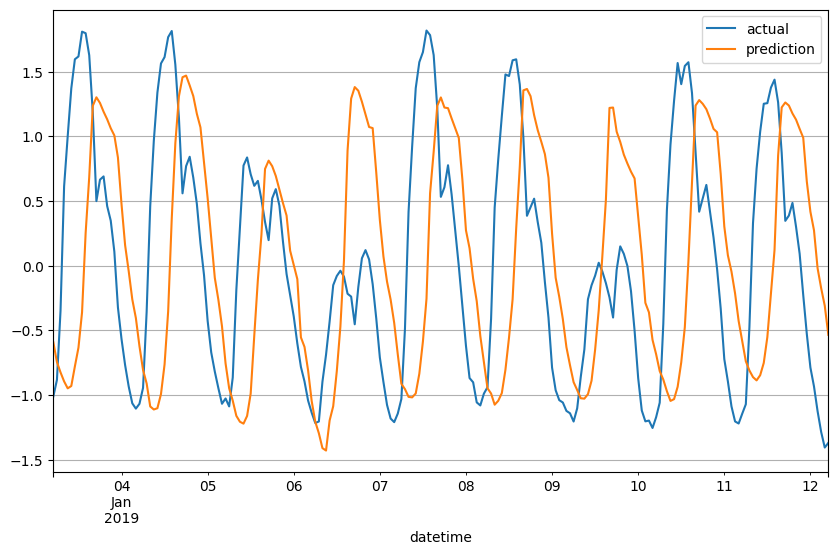

In [33]:
plt.figure(figsize=(10, 6))
df_test.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot(label='actual')
df_sliding.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot(label='prediction')
plt.legend()

# Save Model

In [34]:
os.makedirs('./saved_models', exist_ok=True)

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': hyperparameters,
}

if hyperparameters['use_amp']:
    checkpoint['scaler_state_dict'] = scaler.state_dict()

torch.save(
    checkpoint,
    './saved_models/GPTTimeSeries.pt'
)

### Later: Push **df_sliding** to a database

# Generative Forecast

In [42]:
@torch.no_grad()
def generative_forecast(model, data, num_steps, lag_window_size, use_amp, device):
    model.eval()
    
    predictions = []
    time_indexes = []
    
    # covnert to tensor
    # data.shape: (lags, features)
    lags = torch.tensor(data[-lag_window_size:, :], dtype=torch.float32, device=device)
    
    # artificially add batch dimension
    # (we are not using the dataloader here!)
    # data.shape: (1, lags, features)
    lags = lags.unsqueeze(0)

    # Datetime indexes 
    timestamps = df_full.index
    # Delta time: calculate the time difference between two samples 
    delta_time = timestamps[1] - timestamps[0]
    # Get last timestamp
    current_timestamp = timestamps[-1]

    def generate_date_tensor(_timestamp, _lags, _device):
        _timestamp = _timestamp[-lag_window_size:]
        return torch.tensor([_timestamp.month, _timestamp.day, _timestamp.hour], dtype=torch.float32, device=_device).permute(1, 0)
    
    # single step
    for idx in range(num_steps):

        # get the last lag steps
        lags = lags[:, -lag_window_size:, :]
        #print(lags)

        # date
        date = generate_date_tensor(timestamps, lag_window_size, device).unsqueeze(0)
        
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            forecast_pred = model(lags, date)
        
        # (batch, forecast, output_features_size)-> (1, 1, output_features_size)
        predictions.append(forecast_pred[0][0].cpu().numpy())

        # update current timestamp
        current_timestamp = current_timestamp + delta_time
        time_indexes.append(current_timestamp)

        # append last forecast to the end
        lags = torch.cat((lags, forecast_pred.detach()), dim=1)

        # next timestamp
        timestamps = timestamps + delta_time

    return predictions, time_indexes

In [43]:
pred_generative, time_indexes_generative = generative_forecast(
    model=model, 
    data=df_full.values, 
    num_steps=150, 
    lag_window_size=hyperparameters['lags'], 
    use_amp=hyperparameters['use_amp'], 
    device=device
)

pred_generative_array = np.array(pred_generative)

generative_results_dict = {}

# loop ove features
for feature_id, feature_key in enumerate(df_full.columns):
    generative_results_dict[feature_key] = pred_generative_array[:, feature_id]
        
df_generative = pd.DataFrame(data=generative_results_dict, index=time_indexes_generative)

<Axes: >

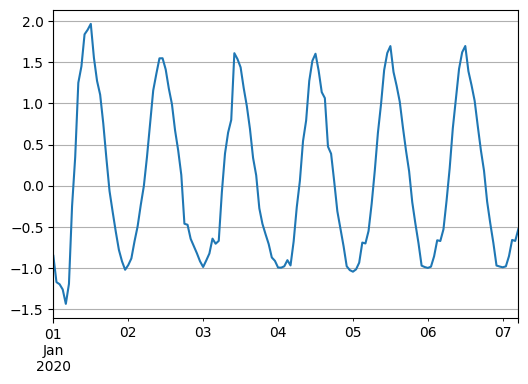

In [44]:
df_generative[selected_feature].plot()